In [2]:
pip install gradio

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install vgg-pytorch

Note: you may need to restart the kernel to use updated packages.


In [2]:
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential,Model
from keras.layers import Dense, Conv2D, MaxPool2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras.layers import Activation
import tensorflow.keras.layers
from keras.preprocessing import image
from keras.preprocessing.image import  ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau as rrp
from keras.applications.vgg16 import VGG16,preprocess_input 
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, accuracy_score, precision_score, recall_score
import cv2
import os
import numpy as np
import pandas as pd
from glob import glob
import gradio

In [6]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 200
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [7]:
train = get_training_data('archive/chest_xray/chest_xray/train')
test = get_training_data('archive/chest_xray/chest_xray/test')
val = get_training_data('archive/chest_xray/chest_xray/val')

OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



<ipython-input-6-149d7cc0a3f4>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



In [8]:
pnenumonia = 0 
normal = 0 

for i, j in train:
    if j == 0:
        pnenumonia+=1
    else:
        normal+=1
        
print('Pneumonia:', pnenumonia)
print('Normal:', normal)
print('Pneumonia - Normal:', pnenumonia-normal)

Pneumonia: 3875
Normal: 1341
Pneumonia - Normal: 2534


# DATA VISUALIZATION

PNEUMONIA


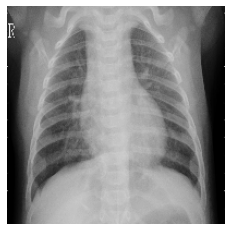

In [9]:
plt.imshow(train[1][0], cmap='gray')
plt.axis('off')
print(labels[train[1][1]])

## We are incoprating the validation data into the training data because it does not contain enough examples.

In [10]:
X = []
y = []

for feature, label in train:
    X.append(feature)
    y.append(label)

for feature, label in test:
    X.append(feature)
    y.append(label)
    
for feature, label in val:
    X.append(feature)
    y.append(label)


# resize data for deep learning 
X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=32)
X_train, X_val, y_train, y_val = tts(X_train, y_train, test_size=0.20, random_state=32)

In [11]:
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

Data Augmentation

In [12]:
# good for balancing out disproportions in the dataset 
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=90, 
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True)  

datagen.fit(X_train)

## CNN(Convoluational Neural Network)

In [13]:
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X_train.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
adam = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 256)     2560      
                                                                 
 activation (Activation)     (None, 200, 200, 256)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 256)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 256)    400       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      147520    
                                                                 
 activation_1 (Activation)   (None, 100, 100, 64)      0

In [15]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=10), 
                    callbacks=[early_stop], 
                    validation_data=(X_val, y_val), epochs=15)

Epoch 1/15
375/375 [==============================] - 934s 2s/step - loss: 0.6160 - acc: 0.7150 - val_loss: 0.5768 - val_acc: 0.7407
Epoch 2/15
375/375 [==============================] - 827s 2s/step - loss: 0.4555 - acc: 0.7790 - val_loss: 0.3627 - val_acc: 0.8068
Epoch 3/15
375/375 [==============================] - 804s 2s/step - loss: 0.3968 - acc: 0.8097 - val_loss: 0.3406 - val_acc: 0.8581
Epoch 4/15
375/375 [==============================] - 909s 2s/step - loss: 0.3586 - acc: 0.8305 - val_loss: 0.2652 - val_acc: 0.8922
Epoch 5/15
375/375 [==============================] - 964s 3s/step - loss: 0.3401 - acc: 0.8481 - val_loss: 0.2440 - val_acc: 0.9093
Epoch 6/15
375/375 [==============================] - 818s 2s/step - loss: 0.3305 - acc: 0.8431 - val_loss: 0.2455 - val_acc: 0.8975
Epoch 7/15
375/375 [==============================] - 905s 2s/step - loss: 0.3040 - acc: 0.8695 - val_loss: 0.2753 - val_acc: 0.8826
Epoch 8/15
375/375 [==============================] - 787s 2s/step - 

In [16]:
model.evaluate(X_test, y_test)

37/37 [==============================] - 63s 2s/step - loss: 0.2321 - acc: 0.9036


[0.23209552466869354, 0.9035836458206177]

## Visualization of Training Process

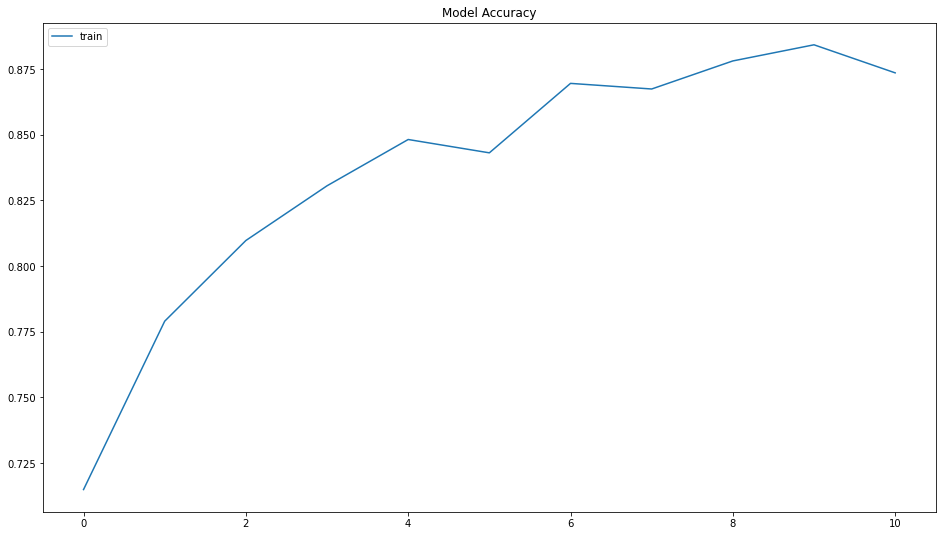

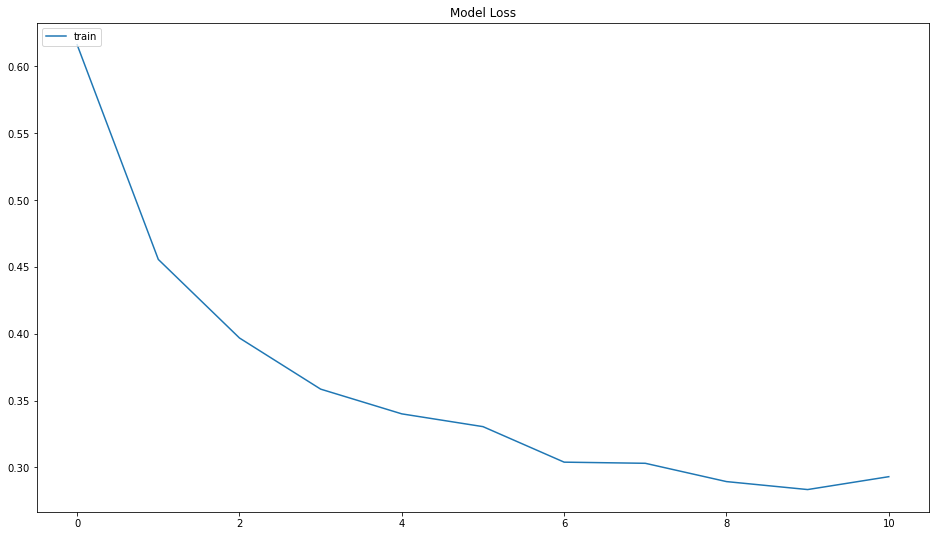

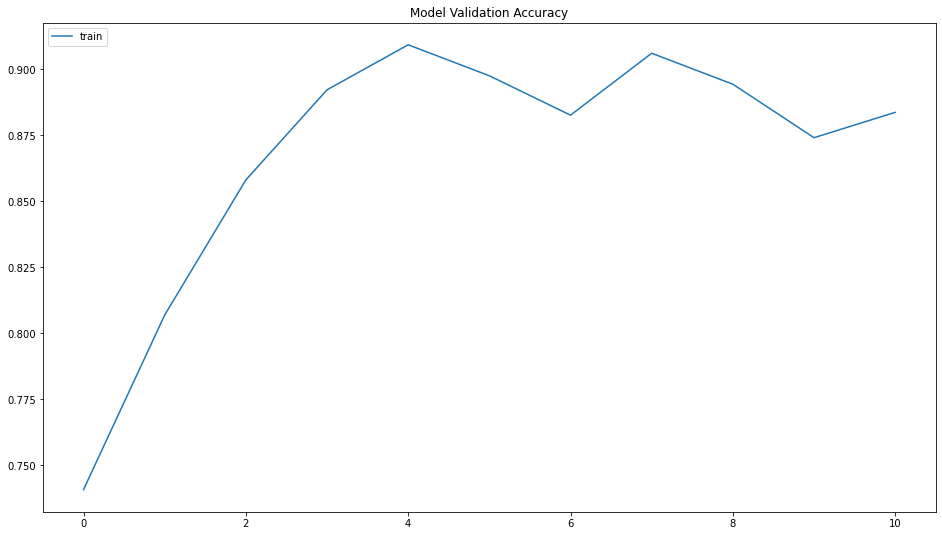

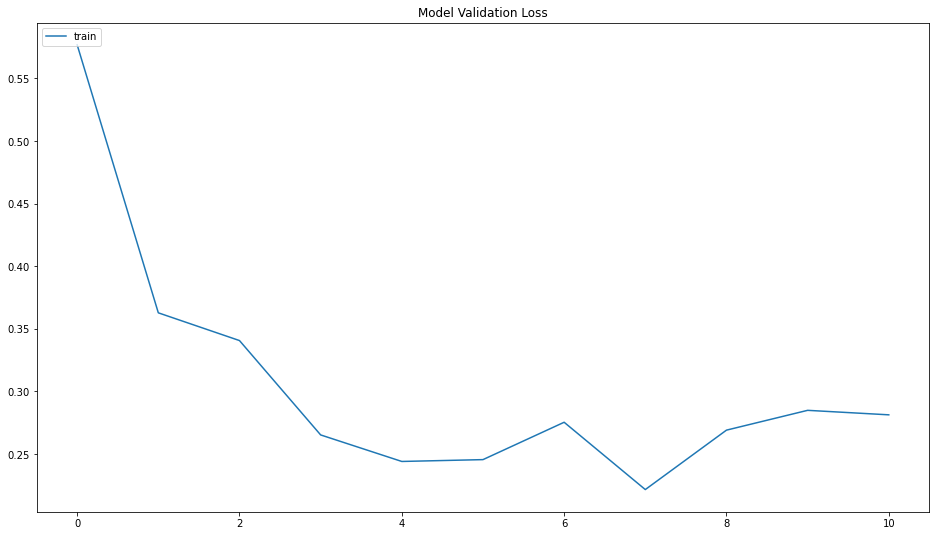

In [17]:
plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['acc'])
plt.title('Model Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['loss'])
plt.title('Model Loss')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['val_acc'])
plt.title('Model Validation Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Model Validation Loss')
plt.legend(['train'], loc='upper left')
plt.show()

### Preparation of Data for Precision vs. Recall and ROC

In [18]:
pred = model.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)
fpr, tpr, thresholds2 = roc_curve(y_train, pred)

118/118 [==============================] - 217s 2s/step


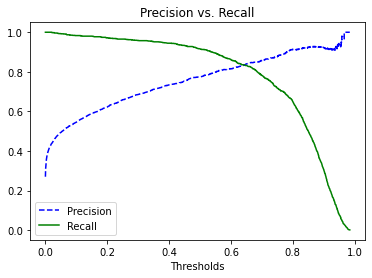

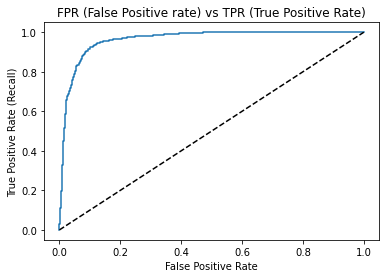

In [19]:
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--')
    plt.plot(thresholds, recalls[:-1], 'g-')
    plt.title('Precision vs. Recall')
    plt.xlabel('Thresholds')
    plt.legend(['Precision', 'Recall'], loc='best')
    plt.show()

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('FPR (False Positive rate) vs TPR (True Positive Rate)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.show()
    
plot_precision_recall(precisions, recalls, thresholds)
plot_roc(fpr, tpr)

In [20]:
predictions = model.predict(X_test)

37/37 [==============================] - 68s 2s/step


Basic Predictions

In [21]:
binary_predictions = []
threshold = thresholds[np.argmax(precisions >= 0.80)]
for i in predictions:
    if i >= threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [22]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.909556313993174
Precision on testing set: 0.9057750759878419
Recall on testing set: 0.7989276139410187


## Confusion Matrix
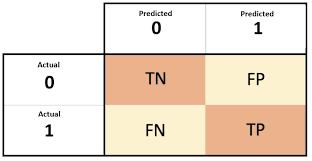

[Text(0, 0.5, 'PNEUMONIA'), Text(0, 1.5, 'NORMAL')]

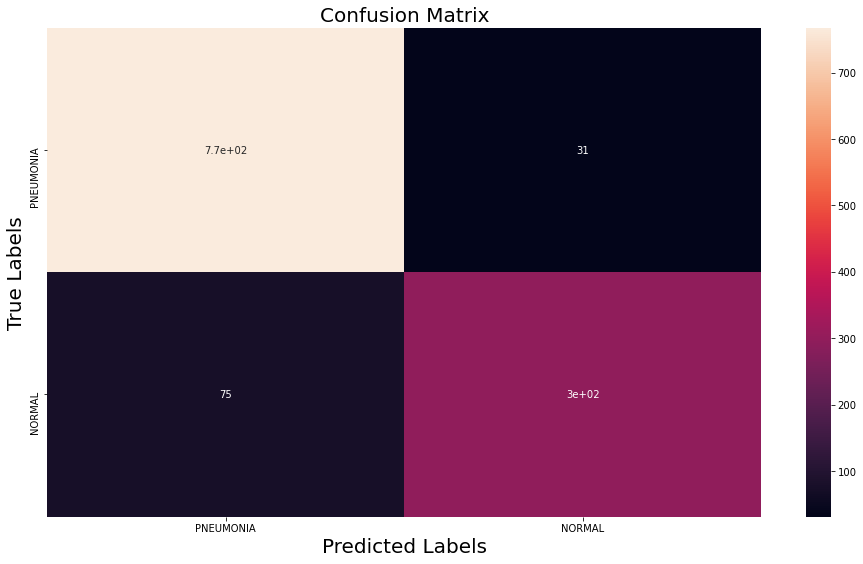

In [23]:
matrix = confusion_matrix(binary_predictions, y_test)
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

## Some Photrographic results

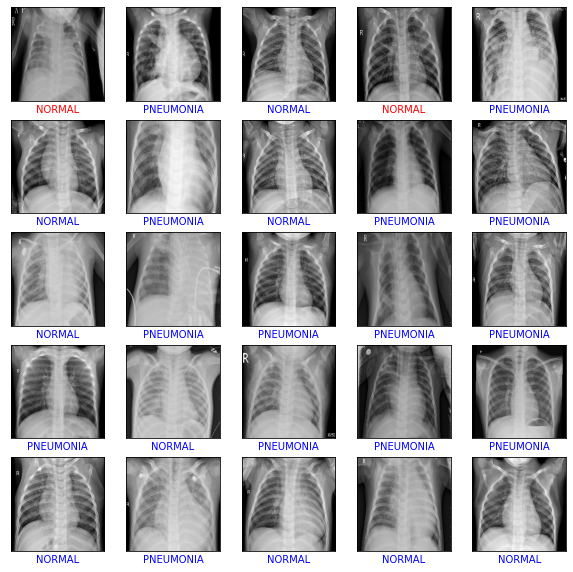

In [24]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train.reshape(-1, img_size, img_size)[i], cmap='gray')
    if(binary_predictions[i]==y_test[i]):
        plt.xlabel(labels[binary_predictions[i]], color='blue')
    else:
        plt.xlabel(labels[binary_predictions[i]], color='red')
plt.show()

### Model Download

In [25]:
 model.save('pneumonia_detection_ai_version_3.h5')

## LOSS and ACCURACY

In [26]:
print("Loss of the model is = ",model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is = ",model.evaluate(X_test,y_test)[1]*100,'%')

37/37 [==============================] - 65s 2s/step - loss: 0.2321 - acc: 0.9036
Loss of the model is =  0.23209552466869354
37/37 [==============================] - 63s 2s/step - loss: 0.2321 - acc: 0.9036
Accuracy of the model is =  90.35836458206177 %


# Gradio Interface

In [27]:
def pneumoniaPrediction(img):
    img = np.array(img)/255
    img = img.reshape(-1, 150, 150, 1)
    isPneumonic = model.predict(img)[0]
    imgClass = 'Normal' if isPneumonic<0.5 else 'Pneumonic'
    return imgClass

In [28]:
for i in range (len(predictions)):
    if predictions[i]>0.5:
        predictions[i]=1
    else:
        predictions[i]=0

In [29]:
img = gradio.Image(shape=(150,150))
label = gradio.Label(num_top_classes=1)

In [31]:
interface = gradio.Interface(fn = pneumoniaPrediction,
                            title ="Pneumonia Prediction",
                            inputs = img,
                            outputs = label,
                            interpretation = 'default',capture_session = True, description= "To see that if you have pneumonia or not").launch(share=True)

D:\CU\anaconda\lib\site-packages\gradio\deprecation.py:40: UserWarning: `capture_session` parameter is deprecated, and it has no effect
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app


Traceback (most recent call last):
  File "D:\CU\anaconda\lib\site-packages\gradio\routes.py", line 393, in run_predict
    output = await app.get_blocks().process_api(
  File "D:\CU\anaconda\lib\site-packages\gradio\blocks.py", line 1108, in process_api
    result = await self.call_function(
  File "D:\CU\anaconda\lib\site-packages\gradio\blocks.py", line 915, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "D:\CU\anaconda\lib\site-packages\anyio\to_thread.py", line 31, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "D:\CU\anaconda\lib\site-packages\anyio\_backends\_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "D:\CU\anaconda\lib\site-packages\anyio\_backends\_asyncio.py", line 867, in run
    result = context.run(func, *args)
  File "<ipython-input-27-077c662256f6>", line 4, in pneumoniaPrediction
    isPneumonic = model.predict(img)[0]
  File "D:\CU\anaconda\lib\site-packages\keras\utils\tr